## Imports and settings

In [1]:
import src

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from os import *
import numpy as np
import sys
import re
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from  matplotlib.animation import FuncAnimation
from matplotlib import colors
from netCDF4 import Dataset
from IPython.display import clear_output
#data folder
sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/data')

In [3]:
import keras.backend as K

In [4]:
#forces CPU usage
environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
environ["CUDA_VISIBLE_DEVICES"] = "-1" #"" or "-1" for CPU, "0" for GPU
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization, TimeDistributed, LSTM
from keras.optimizers import Adam, RMSprop
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3053632972887736700
]


______________________________________-
## Data preprocessing

### Rain measurements
Measurements are downloaded from the DWD (German weather service) open data server: __ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/__<br>
I'm working with the data of August 2010 (based on [this](https://tradingeconomics.com/germany/precipitation)), so I have downloaded this: __ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/radolan/historical/asc/2010/RW-201008.tar__<br>
_DWD manual:_<br>
__ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/radolan/historical/asc/BESCHREIBUNG_gridsgermany_hourly_radolan_historical_asc_de.pdf__<br><br>
This contains radar maps recorded in every hour. Each map has a resolution of $900\times900$ pixels and each pixel corresponds to an $1\,km\times1\,km$ area in reality. Pixel values are the precipitation height in $0.1\,mm$.
Below I'm importing the data of this as a series of numpy arrays and plot them to see the acual radar map. The _sys.path[0]_ is the path on my computer and it can be different for you.

In [ ]:
# look over the data
%matplotlib inline
from  matplotlib.animation import FuncAnimation

fig = plt.figure()
plot = plt.imshow(np.ma.masked_where(inputs[0] < 0, inputs[0])) #inputs 100 has a good mask
plt.colorbar()
plt.xlabel("Longitude pixels")
plt.ylabel("Latitude pixels")
def update(i):
    plot.set_data(np.ma.masked_where(inputs[i] < 0, inputs[i]))
    plt.title(f"Index in array: {i}\nDate: {files[i][9:11]}.{files[i][7:9]}.{files[i][3:7]} {files[i][12:14]}:{files[i][14:16]}")
    plt.savefig(f"{i}")
    return plot

anim = FuncAnimation(fig, update, frames=100, interval = 200, blit=True, repeat=False)

plt.show()

In [ ]:
images = src.generate_datasets(inputs, n=10000, size=64, length=2, normalize=True, split=(6,2,2))

In [5]:
images = np.load(sys.path[0]+"/hourly.npy").item()

In [6]:
#low_res_train = images["low_res_train"]
#low_res_xval = images["low_res_xval"]
#low_res_test = images["low_res_test"]
#overfit = np.reshape(images['images'],np.shape(images['images'])+(1,))
train = np.reshape(images["train"],np.shape(images["train"])+(1,))
xval = np.reshape(images["xval"],np.shape(images["xval"])+(1,))
test = np.reshape(images["test"],np.shape(images["test"])+(1,))
print(f"Training data: {train.shape}\nValidation data: {xval.shape}\nTest data: {test.shape}")

Training data: (6000, 2, 64, 64, 1)
Validation data: (2000, 2, 64, 64, 1)
Test data: (2000, 2, 64, 64, 1)


In [7]:
lstm_train     = np.reshape(train[:,0,:,:,:],((train.shape[0],1,)+train.shape[2:]))
lstm_truth     = np.reshape(train[:,1,:,:,:],((train.shape[0],1,)+train.shape[2:]))
lstm_val       = np.reshape(xval[:,0,:,:,:],((xval.shape[0],1,)+xval.shape[2:]))
lstm_val_truth = np.reshape(xval[:,1,:,:,:],((xval.shape[0],1,)+xval.shape[2:]))
print(lstm_train.shape,"\n",lstm_truth.shape,"\n",lstm_val.shape,"\n",lstm_val_truth.shape)
lstm_test      = np.reshape(test[:,0,:,:,:],((test.shape[0],1,)+test.shape[2:]))
lstm_test_truth = np.reshape(test[:,1,:,:,:],((test.shape[0],1,)+test.shape[2:]))

(6000, 1, 64, 64, 1) 
 (6000, 1, 64, 64, 1) 
 (2000, 1, 64, 64, 1) 
 (2000, 1, 64, 64, 1)


In [ ]:
overfit_train = np.reshape(train[5,0,:,:,:],((1,1,)+train.shape[2:]))
overfit_truth = np.reshape(train[5,1,:,:,:],((1,1,)+train.shape[2:]))

In [ ]:
%matplotlib inline
src.visualise_data(xval[:,:,:,:,0])

## LSTM generator

In [8]:
#batch_size=10
lstm_model = keras.Sequential()
# define CNN model
lstm_model.add(keras.layers.TimeDistributed(keras.layers.Conv2D(
    filters=8, kernel_size=5, strides=2, padding='same', activation='relu'))) #8
lstm_model.add(keras.layers.BatchNormalization())

lstm_model.add(keras.layers.TimeDistributed(keras.layers.Conv2D(
    filters=16, kernel_size=5, strides=2, padding='same', activation='relu')))
lstm_model.add(keras.layers.BatchNormalization())

lstm_model.add(keras.layers.TimeDistributed(keras.layers.Conv2D(
    filters=32, kernel_size=5, strides=2, padding='same', activation='relu')))
lstm_model.add(keras.layers.BatchNormalization())

lstm_model.add(keras.layers.TimeDistributed(keras.layers.Conv2D(
    filters=64, kernel_size=5, strides=2, padding='same', activation='relu')))
lstm_model.add(keras.layers.BatchNormalization())

lstm_model.add(keras.layers.TimeDistributed(keras.layers.Conv2D(
    filters=128, kernel_size=5, strides=4, padding='same', activation='tanh')))
lstm_model.add(keras.layers.TimeDistributed(keras.layers.Flatten()))

#LSTM
lstm_model.add(keras.layers.LSTM(units=128, return_sequences=True))

#upconv
lstm_model.add(keras.layers.Reshape((1,1,1,128)))
lstm_model.add(keras.layers.TimeDistributed(keras.layers.Conv2DTranspose(
    filters=64,kernel_size=5,strides=4,padding='same', activation='relu'))) #64
lstm_model.add(keras.layers.TimeDistributed(keras.layers.Conv2DTranspose(
    filters=32,kernel_size=5,strides=2,padding='same', activation='relu')))
lstm_model.add(keras.layers.TimeDistributed(keras.layers.Conv2DTranspose(
    filters=16,kernel_size=5,strides=2,padding='same', activation='relu')))
lstm_model.add(keras.layers.TimeDistributed(keras.layers.Conv2DTranspose(
    filters=8,kernel_size=5,strides=2,padding='same', activation='relu')))
lstm_model.add(keras.layers.TimeDistributed(keras.layers.Conv2DTranspose(
    filters=1,kernel_size=5,strides=2,padding='same', activation='relu')))

lstm_model.build((None,1,)+train.shape[2:])
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 1, 32, 32, 8)      208       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 32, 32, 8)      32        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1, 16, 16, 16)     3216      
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 16, 16, 16)     64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1, 8, 8, 32)       12832     
_________________________________________________________________
batch_normalization_3 (Batch (None, 1, 8, 8, 32)       128       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 1, 4, 4, 64)       51264     
__________

In [9]:
callback = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
            keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [10]:
lstm_model.load_weights("best_model.h5")

In [11]:
lstm_model.compile(optimizer=tf.train.AdamOptimizer(learning_rate = 0.0001),loss=src.custom_loss(), metrics=[src.relative_error_tensor]) 

***Using L2 + gradient difference loss.***
Tensor("metrics/relative_error_tensor/truediv:0", shape=(), dtype=float32)
Tensor("time_distributed_11_target:0", shape=(?, ?, ?, ?, ?), dtype=float32)


In [12]:
#train the model
lstm_model.fit(lstm_train, lstm_truth,
               validation_data=(lstm_val, lstm_val_truth),
               batch_size = 100,
               epochs=2,
               callbacks=callback,
               shuffle = True)

Train on 6000 samples, validate on 2000 samples
Epoch 1/2
6000/6000 [==============================] - 40s 7ms/step - loss: 0.0442 - relative_error_tensor: 0.8914 - val_loss: 0.0535 - val_relative_error_tensor: 1.1819
Epoch 2/2
6000/6000 [==============================] - 30s 5ms/step - loss: 0.0433 - relative_error_tensor: 0.8823 - val_loss: 0.0534 - val_relative_error_tensor: 1.1960


In [13]:
hist = lstm_model.history
hist.history.keys()

dict_keys(['val_loss', 'val_relative_error_tensor', 'loss', 'relative_error_tensor'])

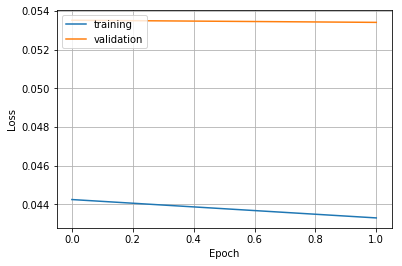

In [14]:
plt.plot(hist.history['loss'],)
plt.plot(hist.history['val_loss'])
plt.grid()
plt.legend(['training', 'validation'], loc='upper left')
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.yscale("log")
plt.savefig('training.png')

In [15]:
#test
predictions = lstm_model.predict(lstm_test, batch_size=50)
truth       = lstm_test_truth
truth.shape

(2000, 1, 64, 64, 1)

In [16]:
args = src.arg_getter(truth, predictions)
args[-1]

C:\Users\pkicsiny\Desktop\TUM\3\ADL4CV\ADL4CV_project\src.py:256: RuntimeWarning: divide by zero encountered in true_divide
  images[i] = np.divide(num, den)


1738

C:\Users\pkicsiny\Desktop\TUM\3\ADL4CV\ADL4CV_project\src.py:256: RuntimeWarning: divide by zero encountered in true_divide
  images[i] = np.divide(num, den)


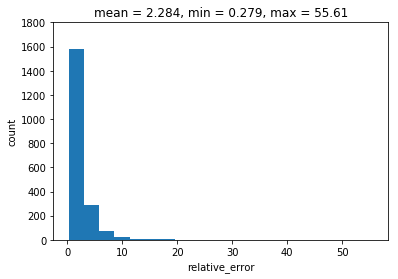

In [17]:
error_images, error_vals, error_means = src.error_distribution(truth,predictions, metric="relative_error")

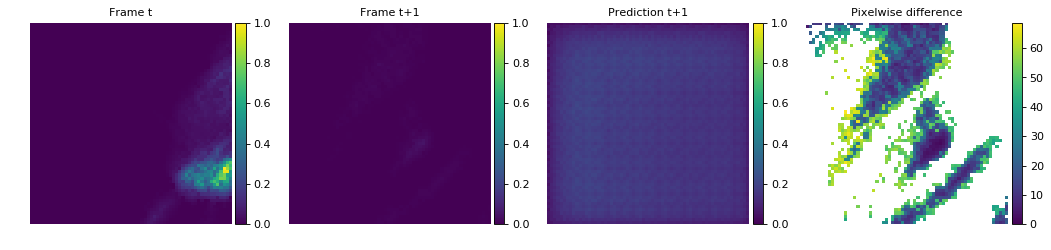

In [18]:
src.result_plotter(args[-1:], (lstm_test[:,0,:,:,0], truth[:,0,:,:,0], predictions[:,0,:,:,0], error_images[:,0,:,:,0]))

## Discriminator

In [ ]:
D = keras.Sequential()
depth = 2
dropout = 0.4

conv1 = keras.layers.Conv2D(filters=depth*1 ,kernel_size=10, strides=5, input_shape=(900,900,1), padding='same')
relu1 = keras.layers.LeakyReLU(alpha=0.2)
dropout1 = keras.layers.Dropout(dropout)

conv2 = keras.layers.Conv2D(filters=depth*2, kernel_size=10, strides=5, padding='same')
relu2 = keras.layers.LeakyReLU(alpha=0.2)
dropout2 = keras.layers.Dropout(dropout)

conv3 = keras.layers.Conv2D(filters=depth*4, kernel_size=6, strides=2, padding='same')
relu3 = keras.layers.LeakyReLU(alpha=0.2)
dropout3 = keras.layers.Dropout(dropout)

conv4 = keras.layers.Conv2D(filters=depth*8, kernel_size=2, strides=2, padding='same')
relu4 = keras.layers.LeakyReLU(alpha=0.2)
dropout4 = keras.layers.Dropout(dropout)

# Out: 1-dim probability
flatten = keras.layers.Flatten()
fcl1 = keras.layers.Dense(1)
sig1 = keras.layers.Activation('sigmoid')
#summary()
D.add(conv1)
D.add(relu1)
D.add(dropout1)
D.add(conv2)
D.add(relu2)
D.add(dropout2)
D.add(conv3)
D.add(relu3)
D.add(dropout3)
D.add(conv4)
D.add(relu4)
D.add(dropout4)
D.add(flatten)
D.add(fcl1)
D.add(sig1)
D.summary()

In [ ]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=0.0001, decay=3e-8)
AM = keras.Sequential()
AM.add(G)
AM.add(D)
AM.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
AM.fit(train_val_inputs,
          train_val_targets,
          batch_size = 50,
          epochs=50,
          validation_split = 0.1,
          shuffle = True)